In [1]:
'''

GUILHERME LIMA DE SOUSA - 
ESTUDO DE CASO: TONELADAS TRANSPORTADAS EM FERROVIAS BRASILEIRAS
OBJETIVO: PREDIÇÃO USANDO RANDOMFORESTREGRESSOR

ENTRE EM CONTATO COMIGO NO LINKEDIN: 
www.linkedin.com/in/guilherme-lima-747355169

'''


import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns


##CONFIGURANDO NUMEROS COM 2 CASAS DECIMAIS
pd.set_option('Float_format','{:.2f}'.format)

## COMPILANDO ARQUIVOS DA PASTA
pasta = 'C:/Users/Guilh/OneDrive/Área de Trabalho/1-MATERIAIS DE ESTUDO/01 - DIVERSOS/01-RANDOMFOREST/1-ANTT_FERROVIAS/01-INPUT'
arquivos = glob.glob(os.path.join(pasta, '*.csv'))
base_original = pd.concat([pd.read_csv(i, sep=';', encoding='latin1') for i in arquivos], ignore_index = True)

## REMOVENDO PONTO DA COLUNA
base_original['TU'] = base_original['TU'].str.replace('.','',regex=False)
base_original['TKU'] = base_original['TKU'].str.replace('.','',regex=False)

## ALTERANDO FORMATAÇÃO DA COLUNA
base_original['TKU'] = base_original['TKU'].fillna(0)
base_original['TKU'] = base_original['TKU'].astype(float)
base_original['TU'] = base_original['TU'].astype(int)
base_original['TKU'] = base_original['TKU'].astype(int)
base_original['Mes_Ano'] = pd.to_datetime(base_original['Mes_Ano'], format='%m/%Y')

## CRIANDO COLUNAS
base_original['MÊS'] = base_original['Mes_Ano'].dt.month
base_original['ANO'] = base_original['Mes_Ano'].dt.year

#REMOVENDO DUPLICADOS E NULOS
base_original = base_original.drop_duplicates()

# VENDO A BASE
base_original.head(-5)

,Mes_Ano,Ferrovia,Mercadoria_ANTT,Estacao_Origem,UF_Origem,Estacao_Destino,UF_Destino,TU,TKU,MÊS,ANO
0,2006-01-01,EFC,Álcool,Itaqui Base Combustível,MA,Marabá,PA,184,136344,1,2006
1,2006-01-01,EFC,Bebidas e Vasilhames,Ponta da Madeira Pêra do Píer,MA,Imperatriz,MA,1636,999596,1,2006
2,2006-01-01,EFC,Cobre,Paraupebas,PA,Ponta da Madeira Cobre,MA,24461,21158765,1,2006
3,2006-01-01,EFC,Ferro Gusa,Açailândia,MA,Ponta da Madeira Pêra do Píer,MA,116272,60345168,1,2006
4,2006-01-01,EFC,Ferro Gusa,Marabá,PA,Ponta da Madeira Pêra do Píer,MA,205242,152700048,1,2006
...,...,...,...,...,...,...,...,...,...,...,...
148653,2023-04-01,RMS,Soja,Marialva,PR,D Pedro II,PR,179173,111120561,4,2023
148654,2023-04-01,RMS,Soja,Marialva,PR,São Francisco do Sul,SC,80527,58531527,4,2023
148655,2023-04-01,RMS,Soja,Maringa,PR,D Pedro II,PR,193917,126386870,4,2023
148656,2023-04-01,RMS,Soja,Maringa,PR,Rio Grande,RS,1710,3610735,4,2023


In [2]:
##############################          EDA (exploratory data analysis)          ##############################
###################################################################################

print('#########################################')
print('EDA - COLUNAS CATEGORICAS')
print('#########################################\n')

# LINHAS E COLUNAS, NULOS e TIPO ?
base_original.info()
print('----------------------------------')

# DUPLICADOS
if base_original.duplicated().sum() > 0:
    print(f'Total de linhas duplicadas e excluidas: {base_original.duplicated().sum()}')
    base_original.drop_duplicates(inplace=True)
else:
    print('Não há dados duplicados')
print('----------------------------------')

## COLUNAS CATEGORICAS
print('#########################################\n')
print('Representatividade das principais colunas')
print('----------------------------------')
print('---------- Ferrovias ----------')
print(base_original['Ferrovia'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Mercadoria_ANTT ----------')
print(base_original['Mercadoria_ANTT'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Estacao_Origem ----------')
print(base_original['Estacao_Origem'].value_counts(normalize=True))
print('----------------------------------')
print('---------- Estacao_Destino ----------')
print(base_original['Estacao_Destino'].value_counts(normalize=True))
print('----------------------------------')
print('---------- UF_Origem ----------')
print(base_original['UF_Origem'].value_counts(normalize=True))
print('----------------------------------')
print('---------- UF_Destino ----------')
print(base_original['UF_Destino'].value_counts(normalize=True))
print('----------------------------------')

#########################################
EDA - COLUNAS CATEGORICAS
#########################################

<class 'pandas.core.frame.DataFrame'>
Index: 148629 entries, 0 to 148662
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Mes_Ano          148629 non-null  datetime64[ns]
 1   Ferrovia         148629 non-null  object        
 2   Mercadoria_ANTT  148629 non-null  object        
 3   Estacao_Origem   148629 non-null  object        
 4   UF_Origem        148629 non-null  object        
 5   Estacao_Destino  148629 non-null  object        
 6   UF_Destino       148629 non-null  object        
 7   TU               148629 non-null  int32         
 8   TKU              148629 non-null  int32         
 9   MÊS              148629 non-null  int32         
 10  ANO              148629 non-null  int32         
dtypes: datetime64[ns](1), int32(4), object(6)
memory usage: 11.3+ MB
-----------

In [15]:
base_original.describe()

,Mes_Ano,TU,TKU,MÊS,ANO,FLAG_MEDIA_TU,FLAG_MEDIA_TKU
count,148629,148629.00,148629.00,148629.00,148629.00,148629.00,148629.00
mean,2013-12-14 09:31:35.153704960,54622.61,19498042.43,6.47,2013.50,0.11,0.15
min,2006-01-01 00:00:00,0.00,-2147483648.00,1.00,2006.00,0.00,0.00
25%,2009-05-01 00:00:00,981.00,392896.00,3.00,2009.00,0.00,0.00
50%,2013-06-01 00:00:00,4490.00,2047935.00,6.00,2013.00,0.00,0.00
75%,2018-08-01 00:00:00,16912.00,8870595.00,9.00,2018.00,0.00,0.00
max,2023-04-01 00:00:00,13858719.00,1920541926.00,12.00,2023.00,1.00,1.00
std,NaN,401341.54,136936386.47,3.46,5.17,0.31,0.35


#########################################
EDA COLUNAS NÚMERICAS
----------------------------------
          Mes_Ano Ferrovia       Mercadoria_ANTT  \
0      2006-01-01      EFC                Álcool   
1      2006-01-01      EFC  Bebidas e Vasilhames   
2      2006-01-01      EFC                 Cobre   
3      2006-01-01      EFC            Ferro Gusa   
4      2006-01-01      EFC            Ferro Gusa   
...           ...      ...                   ...   
148658 2023-04-01      RMS                  Soja   
148659 2023-04-01      RMS                  Soja   
148660 2023-04-01      RMS                  Soja   
148661 2023-04-01      RMS                  Soja   
148662 2023-04-01      RMS                 Ureia   

                       Estacao_Origem UF_Origem  \
0             Itaqui Base Combustível        MA   
1       Ponta da Madeira Pêra do Píer        MA   
2                          Paraupebas        PA   
3                          Açailândia        MA   
4                    

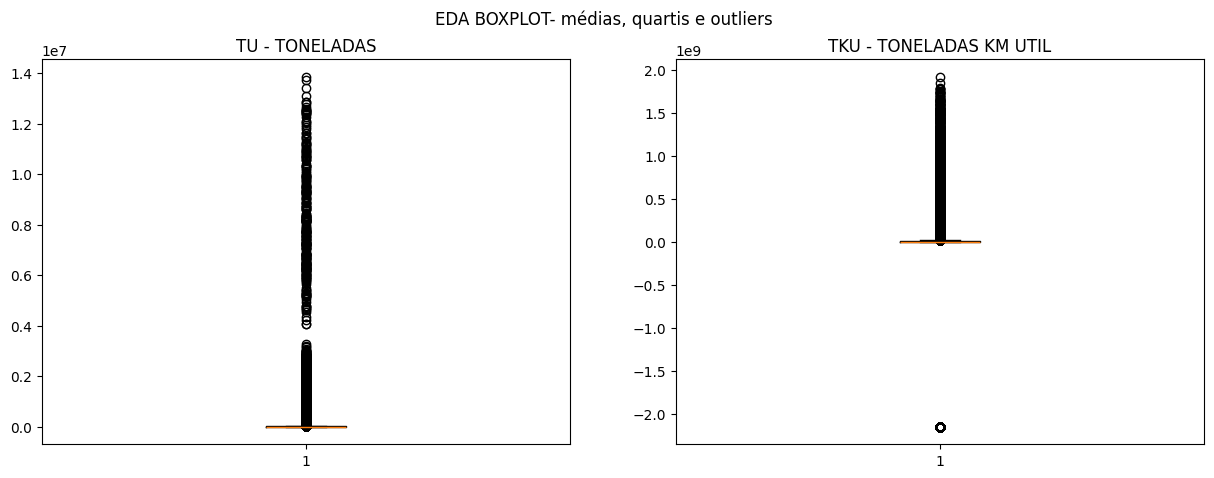

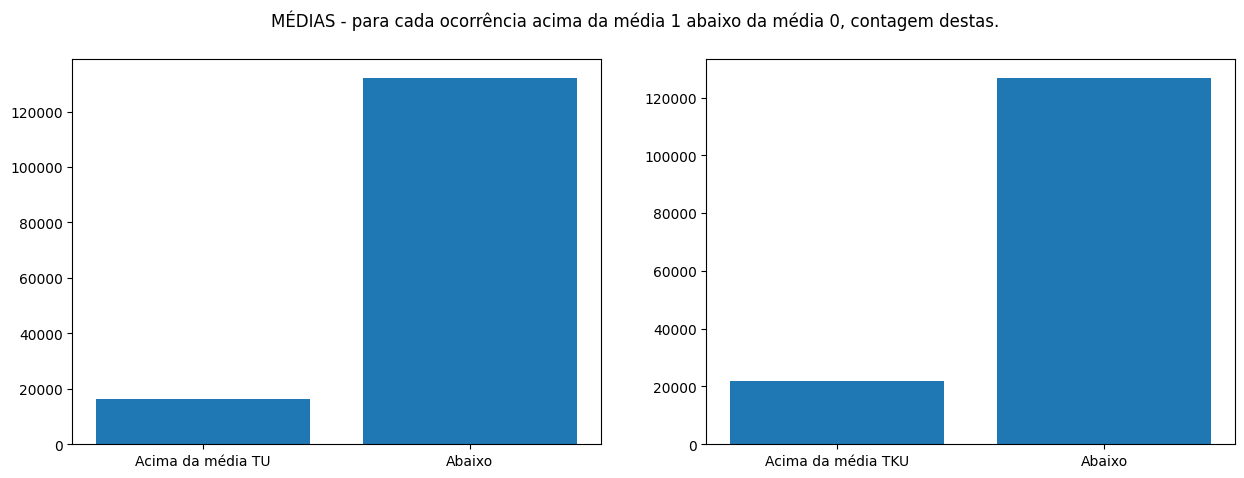

In [16]:
## COLUNAS NÚMERICAS
print('#########################################')
print('EDA COLUNAS NÚMERICAS')
print('----------------------------------')

figura = plt.figure(figsize=(15,5))
figura.suptitle('EDA BOXPLOT- médias, quartis e outliers')

figura.add_subplot(121)
plt.boxplot(base_original['TU'], showfliers=True)
plt.title('TU - TONELADAS')

figura.add_subplot(122)
plt.boxplot(base_original['TKU'], showfliers=True)
plt.title('TKU - TONELADAS KM UTIL')


######
#########################################

# CRIANDO UMA FLAG NA BASE ACIMA OU ABAIXO DA MEDIA
base_original['FLAG_MEDIA_TU'] = np.where(base_original['TU'] >= base_original['TU'].mean(),1,0)
base_original['FLAG_MEDIA_TKU'] = np.where(base_original['TKU'] >= base_original['TKU'].mean(),1,0)
print(base_original)


figura_2 = plt.figure(figsize=(15,5))
figura_2.suptitle('MÉDIAS - para cada ocorrência acima da média 1 abaixo da média 0, contagem destas.')


figura_2.add_subplot(121)
acima_tu = base_original[base_original['FLAG_MEDIA_TU'] == 1]['FLAG_MEDIA_TU'].count()
abaixo_tu = base_original[base_original['FLAG_MEDIA_TU'] == 0]['FLAG_MEDIA_TU'].count()
plt.bar(['Acima da média TU', 'Abaixo'], [acima_tu, abaixo_tu])


figura_2.add_subplot(122)
acima_tku = base_original[base_original['FLAG_MEDIA_TKU'] == 1]['FLAG_MEDIA_TKU'].count()
abaixo_tku = base_original[base_original['FLAG_MEDIA_TKU'] == 0]['FLAG_MEDIA_TKU'].count()
plt.bar(['Acima da média TKU', 'Abaixo'], [acima_tku, abaixo_tku])


plt.show()


#########################################
EDA - FERROVIAS MAIS USADAS EM TONELADAS
----------------------------------


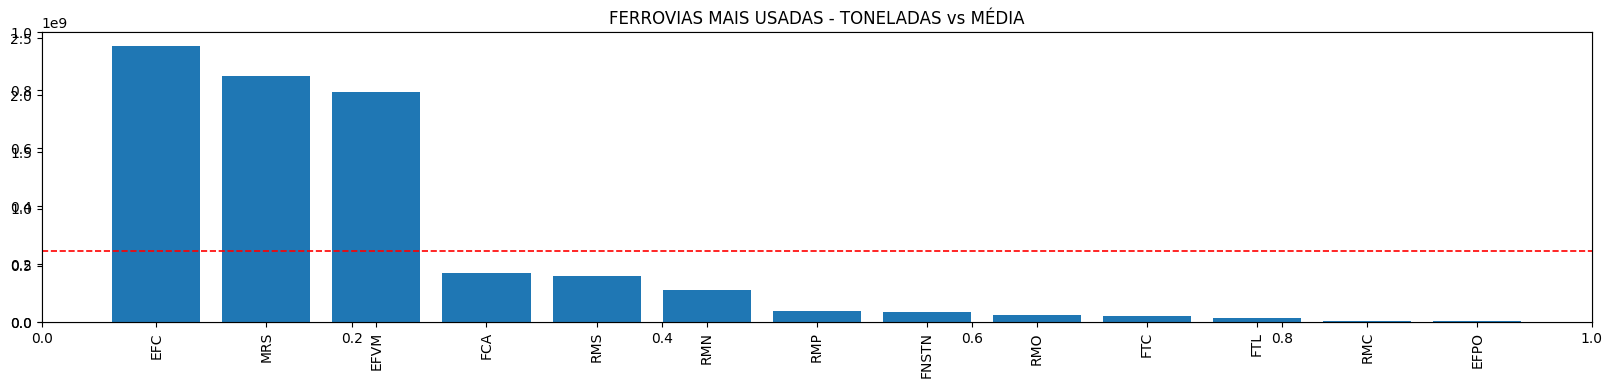

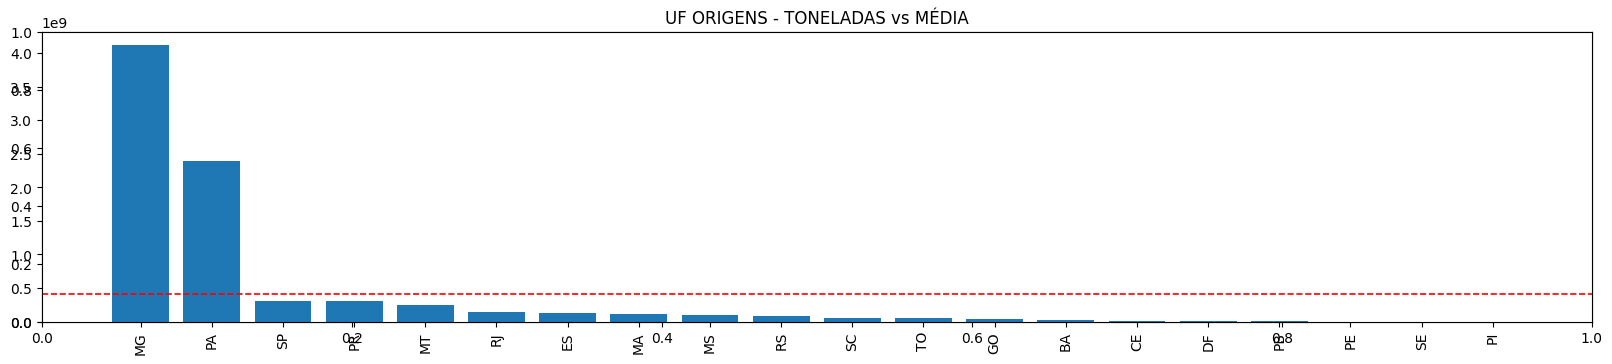

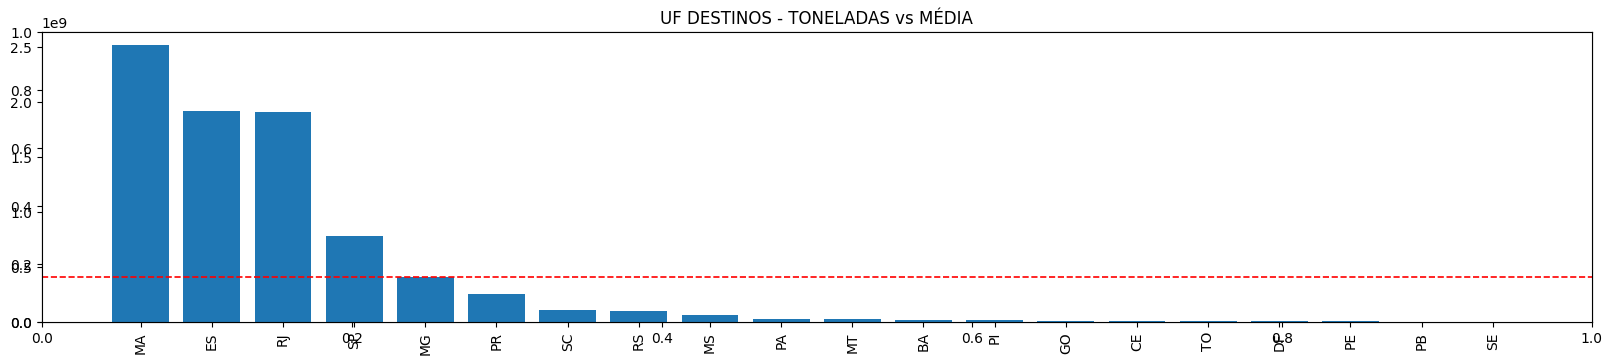

In [17]:
## DISTRIBUIÇÕES DE FREQUÊNCIA
print('#########################################')
print('EDA - FERROVIAS MAIS USADAS EM TONELADAS')
print('----------------------------------')

figura = plt.figure(figsize=(20,5))
plt.title('FERROVIAS MAIS USADAS - TONELADAS vs MÉDIA')


figura.add_subplot(111)
um = base_original.groupby('Ferrovia')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(um['Ferrovia'], um['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(um['TU']), color='red', linestyle='--', linewidth=1.2)



figura2 = plt.figure(figsize=(20,5))
plt.title('UF ORIGENS - TONELADAS vs MÉDIA')

figura2.add_subplot(111)
dois = base_original.groupby('UF_Origem')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(dois['UF_Origem'], dois['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(dois['TU']), color='red', linestyle='--', linewidth=1.2)





figura3 = plt.figure(figsize=(20,5))
plt.title('UF DESTINOS - TONELADAS vs MÉDIA')
figura3.add_subplot(111)
dois = base_original.groupby('UF_Destino')['TU'].sum().reset_index().sort_values(by='TU', ascending=False)
plt.bar(dois['UF_Destino'], dois['TU'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.axhline(y= np.mean(dois['TU']), color='red', linestyle='--', linewidth=1.2)




plt.show()
#teste.sort_values(by='TU', ascending=False)

In [35]:
'''

AQUI VAMOS CRIAR O DATASET DO MODELO

FAZENDO ETL COM AS COLUNAS CATEGORICAS E APLICANDO CÓDIGOS PARA CADA UMA, 
POSTERIORMENTE USANDO AS COLUNAS NUMERICAS REPRESENTADAS COMO VARIAVEIS DO MODELO.
EM VEZ DE USAR O NOME DA FERROVIA ESTAMOS USANDO UM CÓDIGO DISTINTO DELA.

'''




####################################################################################

#     CRIANDO DATASET DO MODELO RANDOMFOREST

####################################################################################


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy import random


np.random.seed(0)


## BASE MODELO
#print(base_original.columns)
print('--------------------')
base_modelo = base_original

# DUMMIES
#base_modelo = pd.get_dummies(base_original)

# TRANSFORMANDO COLUNAS
base_modelo['ANO'] = base_modelo['ANO'].astype(int)
base_modelo['MÊS'] = base_modelo['MÊS'].astype(int)
base_modelo['TU'] = base_modelo['TU'].astype(int)
base_modelo['TKU'] = base_modelo['TKU'].astype(int)

#
############### CRIANDO OS CÓDIGOS DE CADA CATEGORIA
# SELECIONA APENAS AS COLUNAS STRING/CATEGORIAS/OBJETO
categ = base_modelo.select_dtypes(include=['object', 'category']).copy()
# LAMBDA QUE TRANSFORMA AS COLUNAS E NUMEROS
cod_categorica_hoje_1 = categ.apply(lambda col: col.astype('category').cat.codes)
# RENOMEANDO AS COLUNAS DE CODIGO COM PREFIXO
cod_categorica_1 = cod_categorica_hoje_1.add_prefix('Codigo_')


# CONCATENANDO AS BASES DE CODIGOS COM A ORIGINAL
codigos_categorias = pd.concat([base_modelo, cod_categorica_1], axis=1)

print('################# BASE COM DE:PARA ########################')
# BASE COM TUDO
print(codigos_categorias.head(1))


##########  VERIFICANDO DE:PARA DOS CODIGOS
verificar = codigos_categorias[['Ferrovia', 'Codigo_Ferrovia']].drop_duplicates().reset_index(drop=True)
print('################# VERIFICAR ########################')
print(verificar.head(3))



--------------------
################# BASE COM DE:PARA ########################
     Mes_Ano Ferrovia Mercadoria_ANTT           Estacao_Origem UF_Origem  \
0 2006-01-01      EFC          Álcool  Itaqui Base Combustível        MA   

  Estacao_Destino UF_Destino   TU     TKU  MÊS   ANO  FLAG_MEDIA_TU  \
0          Marabá         PA  184  136344    1  2006              0   

   FLAG_MEDIA_TKU  Codigo_Ferrovia  Codigo_Mercadoria_ANTT  \
0               0                0                      98   

   Codigo_Estacao_Origem  Codigo_UF_Origem  Codigo_Estacao_Destino  \
0                    216                 5                     234   

   Codigo_UF_Destino  
0                  9  
################# VERIFICAR ########################
  Ferrovia  Codigo_Ferrovia
0      EFC                0
1     EFPO                1
2     EFVM                2


In [61]:
################################################################ 

# BASE FINAL MODELO

################################################################


# CRIANDO A BASE
base_treino = codigos_categorias.select_dtypes(exclude=['object', 'category']).copy()
base_treino = base_treino.drop(columns=['Mes_Ano'])

#REMOVENDO DUPLICADOS
base_treino = base_treino.drop_duplicates()
base_treino = base_treino.fillna(0)

# SALVANDO BASE DO MODELO COMPLETA SEM FILTROS
base_modelo_completa = base_treino

# LIMITANDO A BASE REMOVENDO 2023
base_treino = base_treino[base_treino['ANO'] != 2023][list(base_treino.columns)]

# REMOVENDO OS OUTLIERS - TUDO QUE ESTÁ MAIOR DO 3º QUARTIL EM TONELADAS
q3 = base_treino['TU'].quantile(0.75)
base_treino = base_treino[base_treino['TU'] <= q3]
base_modelo = base_treino

print('################# BASE MODELO ########################')
print(base_modelo.head(3))

################# BASE MODELO ########################
     TU      TKU  MÊS   ANO  FLAG_MEDIA_TU  FLAG_MEDIA_TKU  Codigo_Ferrovia  \
0   184   136344    1  2006              0               0                0   
1  1636   999596    1  2006              0               0                0   
5  8000  1752000    1  2006              0               0                0   

   Codigo_Mercadoria_ANTT  Codigo_Estacao_Origem  Codigo_UF_Origem  \
0                      98                    216                 5   
1                      11                    316                 5   
5                      44                    365                 5   

   Codigo_Estacao_Destino  Codigo_UF_Destino  
0                     234                  9  
1                     187                  5  
5                     297                  5  


In [62]:
########  VERIFICANDO A BASE ANTES DE ENVIAR AO MODELO
print('##################################################')
print(' O ano maximo dataset de treino é:\n', {base_modelo['ANO'].max()})
print('##################################################')
print(' Colunas da base final:\n', base_modelo.columns)
print('##################################################')
print(base_modelo.info())

##################################################
 O ano maximo dataset de treino é:
 {2022}
##################################################
 Colunas da base final:
 Index(['TU', 'TKU', 'MÊS', 'ANO', 'FLAG_MEDIA_TU', 'FLAG_MEDIA_TKU',
       'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem',
       'Codigo_UF_Origem', 'Codigo_Estacao_Destino', 'Codigo_UF_Destino'],
      dtype='object')
##################################################
<class 'pandas.core.frame.DataFrame'>
Index: 109570 entries, 0 to 146127
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   TU                      109570 non-null  int32
 1   TKU                     109570 non-null  int32
 2   MÊS                     109570 non-null  int32
 3   ANO                     109570 non-null  int32
 4   FLAG_MEDIA_TU           109570 non-null  int32
 5   FLAG_MEDIA_TKU          109570 non-null  int32
 6   Codigo_Fe

In [63]:

'''

HIPÓTESE NULA = SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?


MODELO COM VALIDAÇÃO CRUZADA DE 5 FOLDS CRIADO COM OS PARAMETROS:

MAXDEPTH = 5 
PERMITE CRIAR ARVORES MAIS PROFUNDAS E TRAZ ALEATORIEDADE AOS DADOS, GENERALIZAÇÃO.

N_ESTIMATORS = 10
10 ARVORES DE DECISÃO NO MÁXIMO

RANDOM_STATE = 2
REPLICABILIDADE DE RESULTADOS

'''


############################################################################


#  CIRANDO O MODELO E APLICANDO NA BASE DE TREINO

############################################################################


# DEFININDO X (VAR DEPENDENTE) Y (VAR TARGET)
x = base_modelo.drop(columns=['TU'])
y = base_modelo['TU']


# SEPARANDO TREINO E TESTE
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1)

# CRIANDO MODELO (10 arvores, profundidade 5, replicabilidade seed 2)
modelo = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=2)

# VALIDAÇÃO CRUZADA
kf = KFold(n_splits=5, shuffle= True, random_state=2)
cross_validation = cross_val_score(modelo, x, y, cv=kf, scoring='r2')

# APLICANDO LOG() PARA MELHORAR A DISTRIBUIÇÃO DO MODELO - evita heterocedasticidade
#y_train_log = np.log1p(y_train)


# TREINANDO O MODELO
modelo.fit(x_train, y_train)


# USANDO MODELO NO COJUNTO DE TESTE - PREDIÇÃO
y_pred_test = modelo.predict(x_test)

# OBTENDO R2 DA PREDIÇÃO ANTERIOR
r2_test = r2_score(y_test, y_pred_test)


########## RESULTADOS VALIDAÇÃO CRUZADA
print('----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------')
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"R2 para cada fold (cross-validation): {cross_validation}")
print(f"R2 média (cross-validation): {cross_validation.mean()*100}")
print(f"Desvio padrão (cross validation): {cross_validation.std()}")
print(f"R² no conjunto de teste: {r2_test:.2f}")


###################################################################

#   SALVANDO MODELO

###################################################################


from joblib import dump, load

print('####################################################')
print('----------  SALVANDO MODELO  ----------')
dump(modelo,'ANTT_RANDOMFORESTREGRESSOR.joblib')

----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------
O tipo do modelo carregado é: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
R2 para cada fold (cross-validation): [0.6893367  0.68714959 0.69417033 0.69013356 0.6925576 ]
R2 média (cross-validation): 69.0669554276727
Desvio padrão (cross validation): 0.0024606536822105417
R² no conjunto de teste: 0.69
####################################################
----------  SALVANDO MODELO  ----------


['ANTT_RANDOMFORESTREGRESSOR.joblib']

In [65]:

'''
AQUI APLICAMOS O MODELO NO CENARIO FICTICIO PARA VER COMO ELE GENERALIZA COM OS DADOS EM UM CENÁRIO
DESCONHECIDO

'''


###################################################################

# APLICANDO MODELO NO CENARIO FICTÍCIO

###################################################################

np.random.seed(2)

dataset_inicial = base_modelo_completa

# DUMMIES
#base_modelo = pd.get_dummies(base_original)

# TRANSFORMANDO COLUNAS
dataset_inicial['ANO'] = dataset_inicial['ANO'].astype(int)
dataset_inicial['MÊS'] = dataset_inicial['MÊS'].astype(int)
dataset_inicial['TU'] = dataset_inicial['TU'].astype(int)
dataset_inicial['TKU'] = dataset_inicial['TKU'].astype(int)


## BASE FINAL MODELO
base_cenario = dataset_inicial.select_dtypes(exclude=['object', 'category']).copy()

#DUPLICADOS
base_cenario = base_cenario.drop_duplicates()
base_cenario = base_cenario.fillna(0)

# LIMITANDO A BASE PARA 2023
base_cenario = base_cenario[base_cenario['ANO'] == 2023][list(base_cenario.columns)]

# OUTLIERS
q3 = base_cenario['TU'].quantile(0.75)
base_cenario = base_cenario[base_cenario['TU'] <= q3]

print(' O ano minimo é:', {base_cenario['ANO'].min()})
print('##################################################')
print(' Colunas da base final:\n', base_cenario.columns)
print('################### BASE CENARIO FICTICIO ###############################')
print(base_cenario.head(3))




 O ano minimo é: {2023}
##################################################
 Colunas da base final:
 Index(['TU', 'TKU', 'MÊS', 'ANO', 'FLAG_MEDIA_TU', 'FLAG_MEDIA_TKU',
       'Codigo_Ferrovia', 'Codigo_Mercadoria_ANTT', 'Codigo_Estacao_Origem',
       'Codigo_UF_Origem', 'Codigo_Estacao_Destino', 'Codigo_UF_Destino'],
      dtype='object')
################### BASE CENARIO FICTICIO ###############################
           TU      TKU  MÊS   ANO  FLAG_MEDIA_TU  FLAG_MEDIA_TKU  \
146130  11071  8310998    1  2023              0               0   
146131   7544  3945512    1  2023              0               0   
146132   9466  7080568    1  2023              0               0   

        Codigo_Ferrovia  Codigo_Mercadoria_ANTT  Codigo_Estacao_Origem  \
146130                0                      44                    252   
146131                0                      47                    216   
146132                0                      47                    216   

        Codig

In [69]:

############################################################################

# APLICANDO MODELO


############################################################################


# CARREGANDO MODELO
modelo_cenario = load('ANTT_RANDOMFORESTREGRESSOR.joblib')

##CRIANDO A BASE DO ML UTILIZANDO O STATUS EM BINARIO
cenario_um_completo = base_cenario.drop(columns=['TU'])
cenario_um_target = base_cenario['TU'].values


# VALIDAÇÃO CRUZADA
kf_cenario = KFold(n_splits=5, shuffle= True, random_state=2)
cross_validation_cenario = cross_val_score(modelo_cenario, x, y, cv=kf, scoring='r2')


#FAZENDO AS PREVISOES NO CONJUNTO DE TESTE
pred_cenario_um = modelo_cenario.predict(cenario_um_completo)
acuracia_cenario = r2_score(cenario_um_target, pred_cenario_um)

#RESULTADOS 
print("----------------- ACURACIAS DO MODELO NO CENÁRIO -----------------------------------")
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"acuracia para cada fold (cross-validation): {cross_validation_cenario}")
print(f"R2 média (cross-validation): {cross_validation_cenario.mean()*100}")
print(f"Desvio padrão (cross validation): {cross_validation_cenario.std()}")
print(f"acuracia final do modelo no cenario: {acuracia_cenario:.2f}")

print("---------------------Relatório de Classificação------------------------------")
print("MAE:", mean_absolute_error(cenario_um_target, pred_cenario_um))
print("RMSE:", np.sqrt(mean_squared_error(cenario_um_target, pred_cenario_um)))


'''
##########################################################

####  CENARIO COM MAX_DEPHT = 5

##########################################################

# ACURACIA 
consegue explicar cerca de 65% da variação da variável alvo (TU). Isso é melhor do que um chute aleatório, 
mas ainda distante de um bom ajuste (ideal: acima de 0,70 em muitos contextos). 
Pode indicar que variáveis importantes estão faltando ou que os dados têm muita variabilidade.


# ERRO ABSOLUTO MEDIO - (MAE mean absolute error)
Em média, o modelo erra cerca de 1.931 unidades na previsão de TU. Esse valor deve ser 
interpretado em relação à escala dos dados — se TU varia de 0 a milhões, 
esse erro pode ser tolerável; se não, pode ser alto.


# RMSE - Raiz do erro quadratico médio - (Raise mean squared error)
Esse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como no nosso cenario 3.292) indica que 
há outliers ou erros muito grandes em alguns casos que estão influenciando bastante a performance.


# DESVIO PADRÃO 
O valor estar zerado é incomum. Pode indicar que todas as folds usaram dados muito parecidos (baixa variabilidade) ou que algo 
está errado no particionamento.Sugere verificar se x e y foram bem embaralhados ou se há algum viés nos dados.


###########################################################################################

PARAMETROS

###########################################################################################


# MAX_DEPTH
Quando eu uso max_depth=5 o modelo cria arvores com maior profundidade, arvores profundas demais aprendem todos os detalhes (overfitting)
e arvores rasas demais max_depth=3 aprendem poucos detalhes (underfitting) ....esse ajuste na profundidade permite que as arvores aprendam melhor.

# SHUFFLE
Outro parametro importante no quesito governança e replicabilidade. SHUFFLE = TRUE na validação cruzada (definindo 
os KFOLDs) ela realiza uma reorganização/aleatoriedade nos dados e 
só depois eles são divididos nas amostras das arvores.
Traz a segurança de que seus dados estão aleatoriamente espalhados entres as amostras, sem viés.
Essa parte quebra a suposição do desvio padrão zero.


# VALIDAÇÃO CRUZADA
Tendo sido garantido o parametro de SHUFFLE = TRUE com a aleatoriedade e também devido aos resultados do 
modelo na base de treino terem o R2 para cada fold acima de 65: 
Acurácias para cada fold (cross-validation): [0.6893367  0.68714959 0.69417033 0.69013356 0.6925576]

Com isso podemos anular a hipotese de que há overffiting, que supomos ao ler o desvio padrão, pois os dados foram embaralhados no SHUFFLE = TRUE,
isso indica boa generalização.
'''



----------------- ACURACIAS DO MODELO NO CENÁRIO -----------------------------------
O tipo do modelo carregado é: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
acuracia para cada fold (cross-validation): [0.6893367  0.68714959 0.69417033 0.69013356 0.6925576 ]
R2 média (cross-validation): 69.0669554276727
Desvio padrão (cross validation): 0.0024606536822105417
acuracia final do modelo no cenario: 0.65
---------------------Relatório de Classificação------------------------------
MAE: 1931.7672736575075
RMSE: 3292.9858110767746


'\n##########################################################\n\n####  CENARIO COM MAX_DEPHT = 5\n\n##########################################################\n\n# ACURACIA \nconsegue explicar cerca de 65% da variação da variável alvo (TU). Isso é melhor do que um chute aleatório, \nmas ainda distante de um bom ajuste (ideal: acima de 0,70 em muitos contextos). \nPode indicar que variáveis importantes estão faltando ou que os dados têm muita variabilidade.\n\n\n# ERRO ABSOLUTO MEDIO - (MAE mean absolute error)\nEm média, o modelo erra cerca de 1.931 unidades na previsão de TU. Esse valor deve ser \ninterpretado em relação à escala dos dados — se TU varia de 0 a milhões, \nesse erro pode ser tolerável; se não, pode ser alto.\n\n\n# RMSE - Raiz do erro quadratico médio - (Raise mean squared error)\nEsse erro penaliza mais fortemente grandes erros. Um RMSE muito maior que o MAE (como no nosso cenario 3.292) indica que \nhá outliers ou erros muito grandes em alguns casos que estão influenc

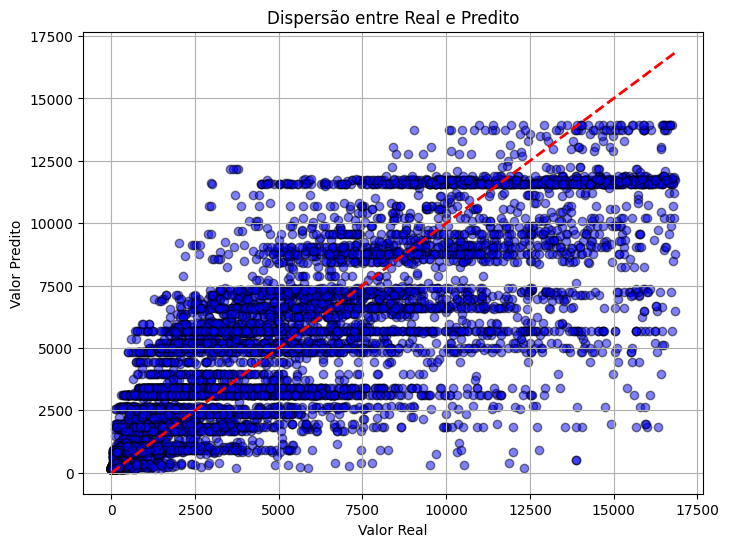

'\n\n## HOMOCEDASTICIDADE\nEm modelos de regressão, a homocedasticidade (erros com variância constante) é uma \nhipótese desejável, pois garante previsões mais estáveis e métricas mais confiáveis.\nSe há heterocedasticidade (o inverso), pode ser que o modelo:\n\n    Não esteja lidando bem com outliers ou valores altos.\n    Precise de uma transformação de escala (como log).\n    Precise ser avaliado com métricas específicas por faixa de valor.\n\nOs valores baixos do real (y_test), fazem os pontos mais agrupados e próximos da linha ideal.\nConforme o valor real (y_test) aumenta, os pontos se espalham mais em torno da linha — o erro aumenta também.\n\n\n## TRANSFORMAÇÃO COM LOG\nAo aplicarmos a transformação de log(1+x) a distribuição do dataset fica mais simetrica, trazendo suavidade e \nbalanceamento \n\n'

In [70]:
########################################################################

# GRAFICO REAL VS PREDITO


########################################################################

plt.figure(figsize=(8,6))

# Pontos: valor real vs valor predito
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue', edgecolors='k')

# Linha ideal (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2)

# Eixos e título
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Dispersão entre Real e Predito")
plt.grid(True)
plt.show()




'''

## HOMOCEDASTICIDADE
Em modelos de regressão, a homocedasticidade (erros com variância constante) é uma 
hipótese desejável, pois garante previsões mais estáveis e métricas mais confiáveis.
Se há heterocedasticidade (o inverso), pode ser que o modelo:

    Não esteja lidando bem com outliers ou valores altos.
    Precise de uma transformação de escala (como log).
    Precise ser avaliado com métricas específicas por faixa de valor.

Os valores baixos do real (y_test), fazem os pontos mais agrupados e próximos da linha ideal.
Conforme o valor real (y_test) aumenta, os pontos se espalham mais em torno da linha — o erro aumenta também.


## TRANSFORMAÇÃO COM LOG
Ao aplicarmos a transformação de log(1+x) a distribuição do dataset fica mais simetrica, trazendo suavidade e 
balanceamento 

'''

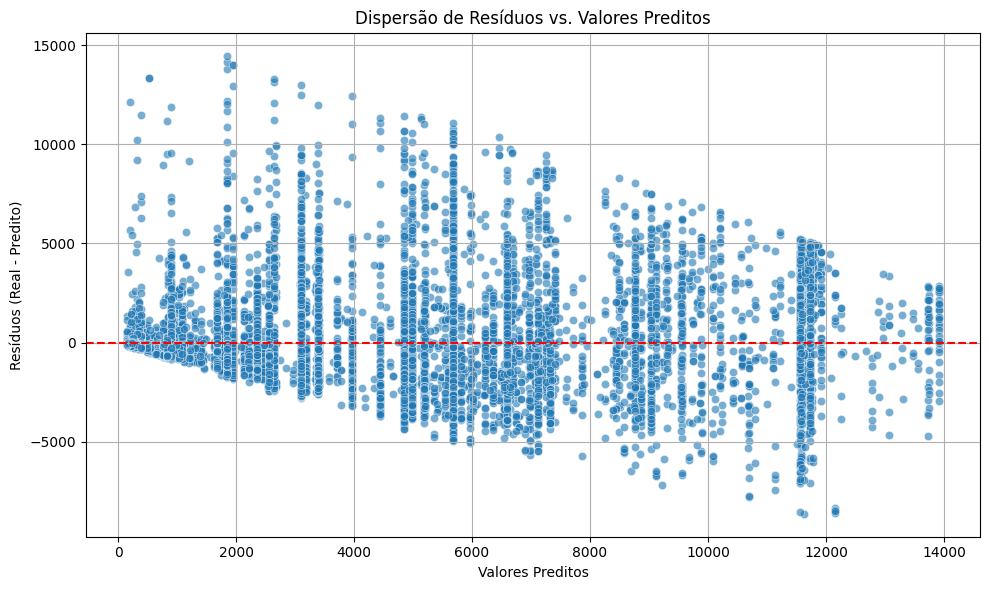

'\n\n# RESIDUOS\nOs residuos estão muito próximos quandos os seus valores são pequenos.\nPara os valores maiores o erro aumenta, mas ainda assim existe a concentração dos pequenos valores.\nEste modelo está apresentando heterocedasticidade, pois a sua dispersão dos erros não é constante....\nCom isso, a suposição de linearidade para alcancar a homocedasticidade não está sendo atendido.\n\n\n# MEXER NA BASE REMOVER OUTLIERS\n-------OPÇÃO EM STANDBY, AINDA NÃO VERIFICADA.\nVamos remover os valores acima do 3 quartil, deixando apenas quem é menor ou igual.\ndesta forma poderemos ter mais assertividade e dispersão homocedastica dos residuos.\n\n'

In [71]:
########################################################################

# GRAFICO REAL VS RESIDUOS


########################################################################



# 1. Calcular os resíduos
residuos = y_test - y_pred_test

# 2. Plotar gráfico de resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Dispersão de Resíduos vs. Valores Preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos (Real - Predito)")
plt.grid(True)
plt.tight_layout()
plt.show()


'''

# RESIDUOS
Os residuos estão muito próximos quandos os seus valores são pequenos.
Para os valores maiores o erro aumenta, mas ainda assim existe a concentração dos pequenos valores.
Este modelo está apresentando heterocedasticidade, pois a sua dispersão dos erros não é constante....
Com isso, a suposição de linearidade para alcancar a homocedasticidade não está sendo atendido.


# MEXER NA BASE REMOVER OUTLIERS
-------OPÇÃO EM STANDBY, AINDA NÃO VERIFICADA.
Vamos remover os valores acima do 3 quartil, deixando apenas quem é menor ou igual.
desta forma poderemos ter mais assertividade e dispersão homocedastica dos residuos.

'''

In [72]:
'''

####################################################################

A TABELA DE PREDIÇÕES AJUDA A ENTENDER O COMPORTAMENTO DO MODELO, PERMITE
VISUALIZAR AS COLUNAS DE VALORES REAIS vs VALORES PREDITOS.S

'''


# TABELA FINAL DE RESULTADOS:
y_true = base_cenario['TU'].values
y_pred = pred_cenario_um


resultados = pd.DataFrame({
    'Valor Real': y_true,
    'Valor Predito': y_pred,
    'Erro Absoluto': abs(y_true - y_pred),
    'Erro Percentual (%)': abs((y_true - y_pred) / y_true) * 100
})

# Visualizando as primeiras linhas
print(resultados.info())
print(resultados.head(50))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1901 entries, 0 to 1900
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Valor Real           1901 non-null   int32  
 1   Valor Predito        1901 non-null   float64
 2   Erro Absoluto        1901 non-null   float64
 3   Erro Percentual (%)  1901 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 52.1 KB
None
    Valor Real  Valor Predito  Erro Absoluto  Erro Percentual (%)
0        11071       11600.33         529.33                 4.78
1         7544        7177.64         366.36                 4.86
2         9466       11553.94        2087.94                22.06
3         9654        5669.67        3984.33                41.27
4        21664       11730.03        9933.97                45.85
5         4360        3098.52        1261.48                28.93
6         2109        1851.75         257.25                12.20
7         

In [ ]:
'''

HIPÓTESE NULA:
    SERÁ QUE MEU MODELO CONSEGUE EXPLICAR AS TONELADAS TRANSPORTADAS
    APENAS COM AS DEMAIS COLUNAS DO NOSSO DATASET ?

REPSOSTA:
    A HIPÓTESE NULA FOI ACEITA, POIS O MODELO SÓ EXPLICA 65% DOS DADOS E APRESENTA HETEROCEDASTICIDADE,
    QUANTO MAIOR OS VALORES REAIS, MAIOR FOI O ERRO DO MEU MODELO.


'''